# Computational Graphs

Version 1.02

(C) 2020 - Umberto Michelucci, Michela Sperti

This notebook is part of the book _Applied Deep Learning: a case based approach, **2nd edition**_ from APRESS by [U. Michelucci](mailto:umberto.michelucci@toelt.ai) and [M. Sperti](mailto:michela.sperti@toelt.ai).

## Notebook Learning Goals

At the end of the notebook you are going to have a clear idea of Computational Graphs foundations and, having seen a practical example, you are going to intuitively comprehend why they are a fundamental tool necessary for efficient code writing and why they are the philosophical concept at the base of TensorFlow (from version 1.X to version 2.X).

## TensorFlow Setup

In this notebook, we want to use TensorFlow version 1.X over 2.X. This is possible in Google Colab, using %tensorflow_version *decorator*. The reasons is that with TensorFlow 1 is easier to see how Computational Graph comes into play when developing neural networks model. In TensorFlow 2.X, computational graphs are present but more hidden and therefore more difficult to study easily.

In [ ]:
# We select TensorFlow version 1.X
%tensorflow_version 1.x 

TensorFlow 1.x selected.


## Libraries Import

This section contains the necessary libraries (such as tensorflow or matplotlib) you need to import to run the notebook.

In [ ]:
# general libraries
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# tensorflow libraries
import tensorflow as tf

# ignore warnings
import warnings
warnings.simplefilter('ignore')

In [ ]:
# check tensorflow version
print(tf.__version__)

1.15.2


Now we clone the repository for the book to be able to access the modules that we have written for all the juypter notebooks.

In [ ]:
# Referring to the following cell, if you want to re-clone a repository
# inside the google colab instance, you need to delete it first. 
# You can delete the repositories contained in this instance executing 
# the following two lines of code (deleting the # comment symbol).

# !rm -rf ADL-Book-2nd-Ed 

In [ ]:
# This command actually clone the repository of the book in the google colab
# instance. In this way this notebook will have access to the modules
# we have written for this book.

# Please note that in case you have already run this cell, and you run it again
# you may get the error message:
#
# fatal: destination path 'ADL-Book-2nd-Ed' already exists and is not an empty directory.
# 
# In this case you can safely ignore the error message.

!git clone https://github.com/toelt-llc/ADL-Book-2nd-Ed.git

Cloning into 'ADL-Book-2nd-Ed'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 849 (delta 9), reused 13 (delta 6), pack-reused 833
Receiving objects: 100% (849/849), 60.20 MiB | 39.98 MiB/s, done.
Resolving deltas: 100% (403/403), done.


In [ ]:
# This cell imports some custom written functions that we have created to 
# make the loading of the data and the plotting easier. You don't need 
# to undertsand the details and you can simply ignore this cell.
# Simply run it with CMD+Enter (on Mac) or CTRL+Enter (Windows or Ubuntu) to
# import the necessary functions.

import sys
sys.path.append('ADL-Book-2nd-Ed/modules/')

from style_setting import set_style
from import_image import display_image

## Computational Graphs

In a nutshell, a computational graph is an abstract way of describing computations as a [directed graph](https://en.wikipedia.org/wiki/Directed_graph). A directed graph is a data structure consisting of nodes (vertices) and edges. Each node corresponds to an operation
or a variable. Variables can feed their values into operations, and operations can feed their results into other operations. Usually, nodes are plotted as a circle (or ellipsis), with variable names or operations inside, and when one node’s value is the input to another node, an arrow goes from one to another. It normally describes a set of operations, their order and their dependencies. 

TensorFlow is strongly based on computational graphs (both versions 1 and 2). Therefore it is important to understand why they are so important. 

One of the main reasons is that we can use the topology of the graph to execute the nodes in the most efficient manner, e.g. using multiple GPUs on a single machine or even distribute the execution across multiple machines. In fact if nodes have no dependencies from one another, we can execute them in parallel, making the execution of the entire graph faster. Having a graph allows TensorFlow to place different operations on different piece of hardware (or CPUs) for example, or schedule them in the most efficient way possible automatically.

There is another more deep reason. A computational graph is a language agnostic way of representing a set of operations. Having the graph allows us to substitute some operations with versions written in different languages (C for example), or even write the entire graph in a completely different language entirely. For example to run specific operations on dedicated hardware ([like TPUs on the edge, like in Coral Devices](https://coral.ai/docs/edgetpu/tflite-python/)) you can invoke, for specific operations, [delegates](https://www.fast.ai/2019/08/06/delegation/) that are specific pieces of software that are developed specifically for the dedicated hardware. Using delegates without a computational graphs would be really hard to do.

### Example 

Let's look at an example. A basic computational graph for the computation of $z=x+2y$ is represented in the following picture. 

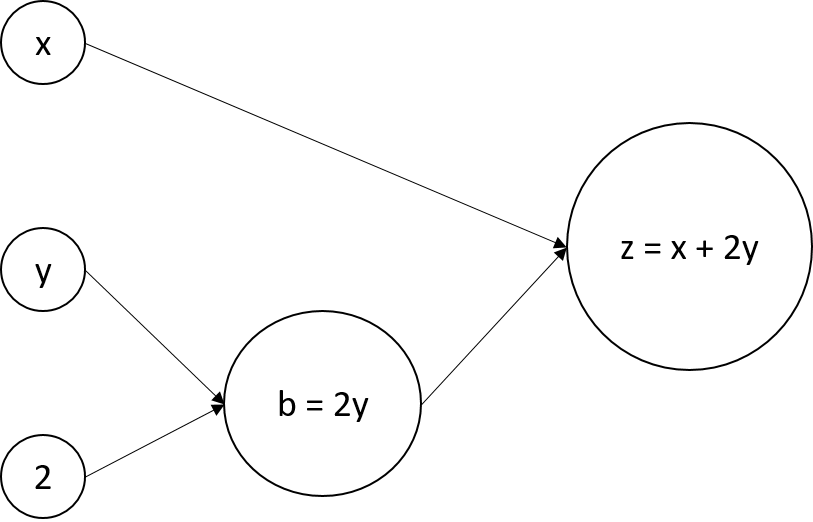

In [ ]:
di = display_image() # display picture
di.display_img('CG.png','chapter11')

An important aspect to understand is that such a graph only *defines* the operations, describing *how* they must be performed (this is called the computational graph's **construction phase**). To actually execute the operations and computing the result, values have to be assigned to the inputs $x$ and $y$ (this is called the computational graph's **evaluation phase**).

Note that the input variables do not need to be real numbers. They can be matrices, vectors, and so on.

### Construction Phase

The following lines create the computational graph described in the picture above and assign the value 1 to x and 2 to y. Note that in this phase no evaluation takes place.

In [ ]:
# We use constant values to define the inputs of our computational graph and all
# the operations contained in it.

x = tf.constant(1) # node x
y = tf.constant(2) # node y
c = 2 # the third node is simply a number, while the two previous nodes can be 
      # matrices, vectors, etc.

b = tf.multiply(y,c) # node b
z = tf.add(x,b) # node z

In a normal Python code ```z``` would contain the result we expect. Let's check what it contains now.

In [ ]:
print(z)

Tensor("Add:0", shape=(), dtype=int32)


As you can see the variable ```z``` does not contain any value. We only know that is a ```Tensor```, that is a scalar (```shape=()```) and that is an integer (```dtype=int32```). But no value has been assigned to it since we have only constructed the computational graph at this point.

### Evaluation Phase

The following lines create a session and run the graph. A ```Session``` is a Python object that connects the graph to the hardware so that can be executed with the method ```run()```.

In [ ]:
sess = tf.Session()
print(sess.run(z))
sess.close()

5


Now you can see that we get the result since we have evaluated the graph. Note that ```z``` does not yet contain any value as can be easily checked.

In [ ]:
print(z)

Tensor("Add:0", shape=(), dtype=int32)


## Practical Example: Solving a Differential Equation Numerically

Differential equations can describe nearly all systems whose behaviour changes over time. They are applied in lots of fields, from engineering to economics, social science, biology, etc.

In the following cells we are going to solve a differential equation numerically, describing it through a computational graph in TensorFlow. The equation is the one which describes the position of a mass $m$ attached to a spring of stiffness $k$:

$$
m \frac{d^2x}{dt^2}+kx=0
$$

The problem's initial conditions are $x(0)=1\,\textrm{m}$ and $dx / dt=0\,\text{m/s}$. 

$m=5\,\text{kg}$ and $k=5\,\textrm{N/m}$.

We can describe the problem with the following computational graph. 

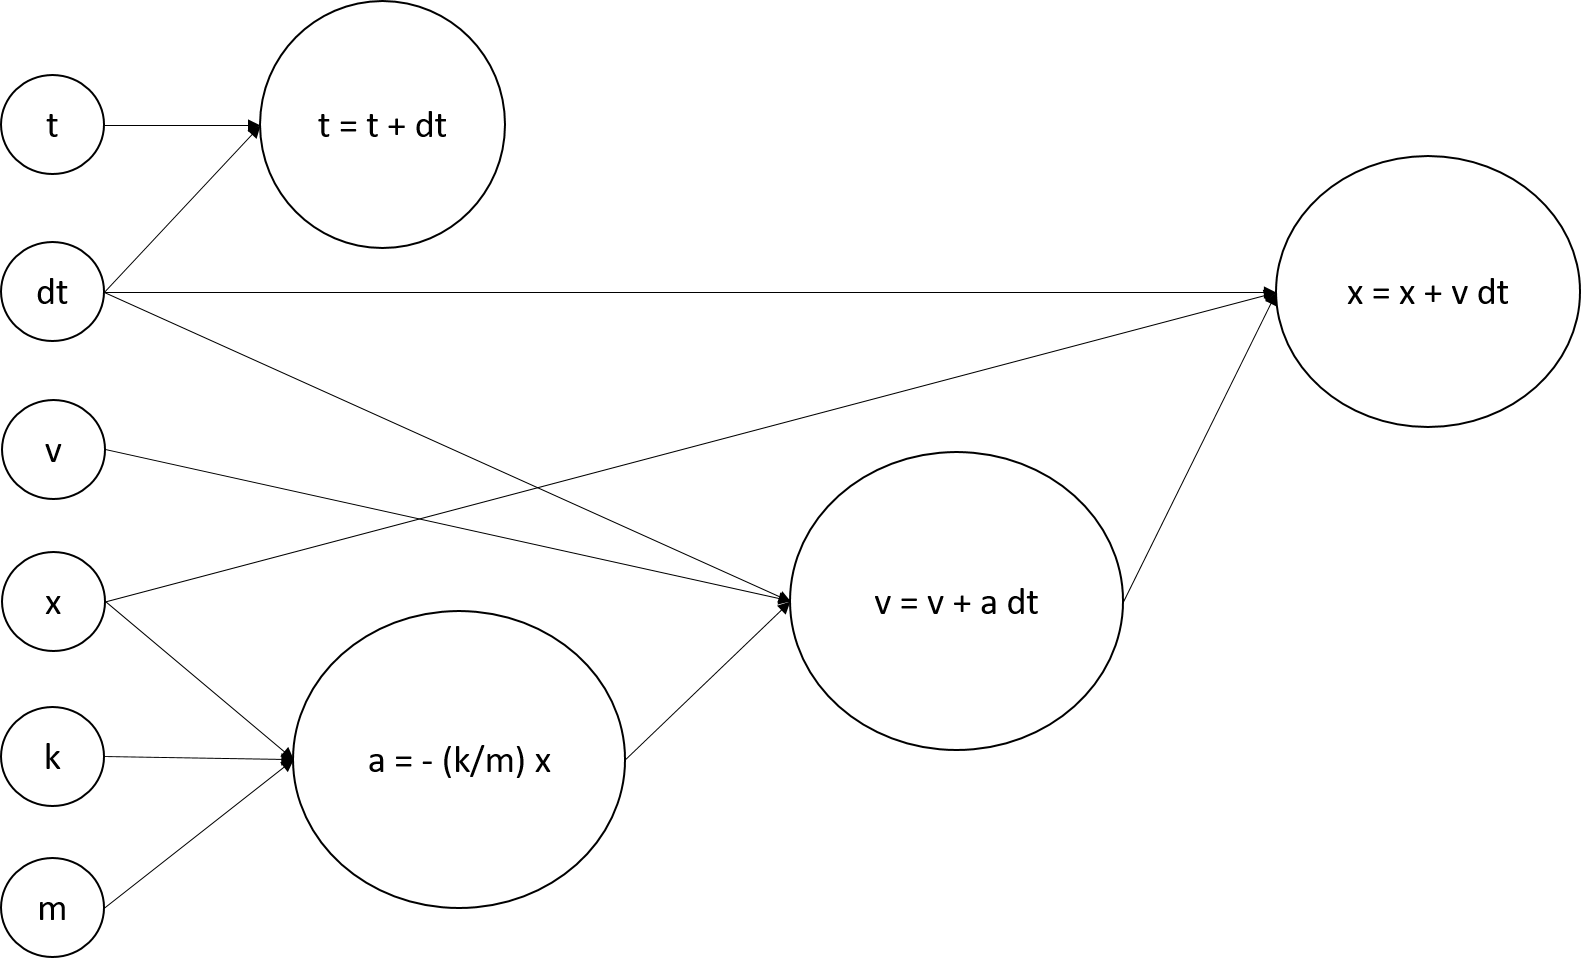

In [ ]:
di = display_image() # display picture
di.display_img('CGeq.png','chapter11')

Let's define each node of the computational graph (variables and operations on them).

In [ ]:
# Computational graph's construction phase
# First we define variables

t = tf.Variable(0.0) # initial time, s
x = tf.Variable(1.0) # initial position, m
v = tf.Variable(0.0) # initial velocity, m/s

m = tf.constant(5.0) # mass, kg
k = tf.constant(5.0) # spring stiffness, N/m
dt = tf.constant(0.1) # time's interval, s

In [ ]:
# Then we define operations

a = tf.multiply(-1.0,tf.multiply(tf.divide(k,m),x)) # acceleration
update_v = v.assign(tf.add(v,tf.multiply(a,dt))) # velocity
update_t = t.assign(tf.add(t,dt)) # time
update_x = x.assign(tf.add(x,tf.multiply(v,dt))) # position

The following line contains the path to fonts that are used to plot result in a uniform way.

In [ ]:
# You can safely ignore this cell, just executing it.
f = set_style().set_general_style_parameters()

Let's evaluate our built graph.

In [ ]:
# Computational graph's evaluation phase

init = tf.global_variables_initializer() # initialize computational graph's variables
t_list,x_list,v_list = [],[],[] # these lists are needed to plot results

with tf.Session() as sess: # create session to evaluate compuational graph
  sess.run(init) # run inizialization
  interval = 0.0
  while interval < 30.0: # simulate solutions for different times
    velocity = update_v.eval() # update velocity
    interval = update_t.eval() # update time's interval
    position = update_x.eval() # # update position
    t_list.append(interval)
    x_list.append(position)
    v_list.append(velocity)
sess.close() # always remember to close session to free resources

Let's finally plot our results: spring's position and velocity as a function of time.

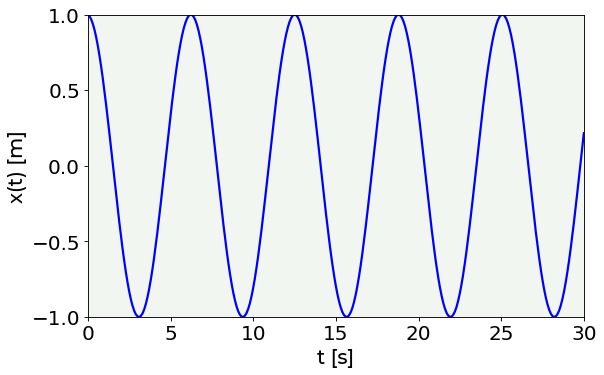

In [ ]:
# Position versus time plot

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(t_list, x_list, color = 'blue')
plt.ylabel('x(t) [m]', fontproperties = fm.FontProperties(fname = f))
plt.xlabel('t [s]', fontproperties = fm.FontProperties(fname = f))
plt.ylim(-1, 1)
plt.xlim(0, 30)
plt.axis(True)
plt.show()

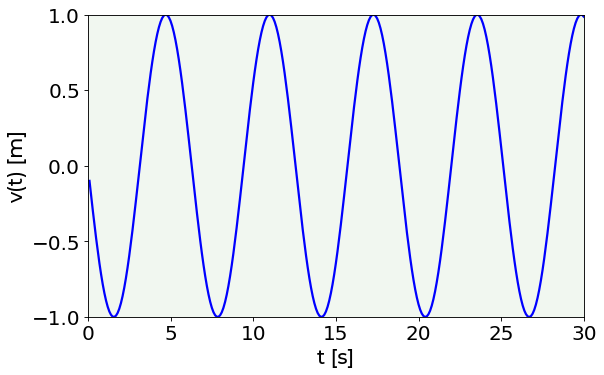

In [ ]:
# Velocity versus time plot

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(t_list, v_list, color = 'blue')
plt.ylabel('v(t) [m]', fontproperties = fm.FontProperties(fname = f))
plt.xlabel('t [s]', fontproperties = fm.FontProperties(fname = f))
plt.ylim(-1, 1)
plt.xlim(0, 30)
plt.axis(True)
plt.show()

## TensorBoard

TensorFlow provides a useful free resource to visualize your computational graphs and check whether they have been correctly designed: [TensorBoard](#fr). TensorBoard is a graphs' dashboard that enables **op-level** graphs' visualization and **conceptual** graphs' visualization.

TensorBoard works by reading the log files which you place inside the specified `--logdir` and creates a web server, enabling you to visualize your graphs by using a browser.

Remember that this is only a visualization tool, therefore, if you execute it, you can just see a description of your graph, but no computation will be performed.

## Exercises

1. [*Easy Difficulty*] Create and evaluate a computational graph which performs the following operation: $z=w_1y+w_2y$, where $y=x^2$ and $x$, $w_1$, and $w_2$ are scalars (you decide which values assign to them).
2. [*Medium Difficulty*] Create and evaluate a computational graph which performs the following operation: $z=w_1y+w_2y$, where $y=x^2$ and $x$, $w_1$, and $w_2$ are vectors (you decide which values assign to them).
3. [*Hard Difficulty*] Try to solve numerically the following differential equation: $ \frac{d^2x}{dt^2}+3\frac{dx}{dt}+5x=0
$. Define it by a computational graph, like in the example seen in the notebook.

## Further Readings <a name = "fr"></a>

**TensorBoard**

1. Tensorboard for computational Graphs: https://www.tensorflow.org/tensorboard/graphs